In [87]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import uncertainties as unc

In [88]:
def transfer(F, C, D):
    R = D/(2*np.pi*F*C)
    RparallelC = (1/((1/10e6)**2+ (2*np.pi*F*(C+25e-12))**2)**0.5)
    return np.abs(RparallelC/(RparallelC+R))

def curveFit(f, f4, a):
    return (f4*f**-a)

def readData(fileName: str):
    data = pd.read_csv(fileName, sep="\t", header=None)
    return data[0], data[1]
def expected(f, c, d, T):
    return (4*1.380649e-23*T*(d/(2*np.pi*f*c)))**0.5

def expectedSlope(c,d,T):
    return (4*1.380649e-23*T/(2*np.pi*c))**0.5



In [89]:
_, uncsV = readData("uncs.txt")
five = uncsV[0:20]
hundred = uncsV[20:40]
thousand = uncsV[40:60]
uncPctFive = np.std(five)/np.mean(five)
uncPctHundred = np.std(hundred)/np.mean(hundred)
uncPctThousand = np.std(thousand)/np.mean(thousand)
print(uncPctFive, uncPctHundred, uncPctThousand)

0.06405111704962811 0.14300066995941668 0.20380011074927695


Expected:  (7.4347+/-0.0015)e-06
Fit:  [3.27213337e-06 4.04426518e-01] [[9.73088040e-13 7.93414211e-08]
 [7.93414211e-08 7.74727921e-03]]


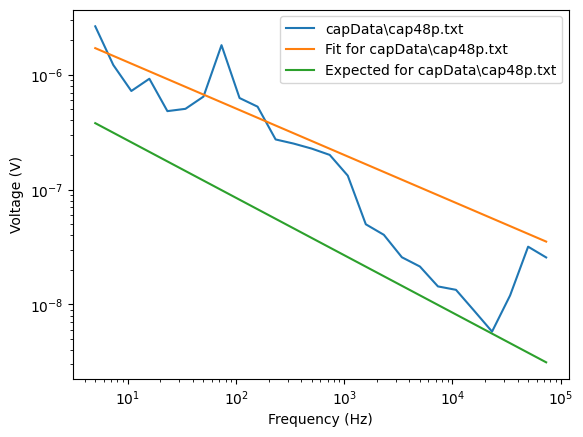

Expected:  (6.5872+/-0.0012)e-06
Fit:  [2.01797734e-06 3.53874691e-01] [[1.47506403e-13 2.01120720e-08]
 [2.01120720e-08 3.38071744e-03]]


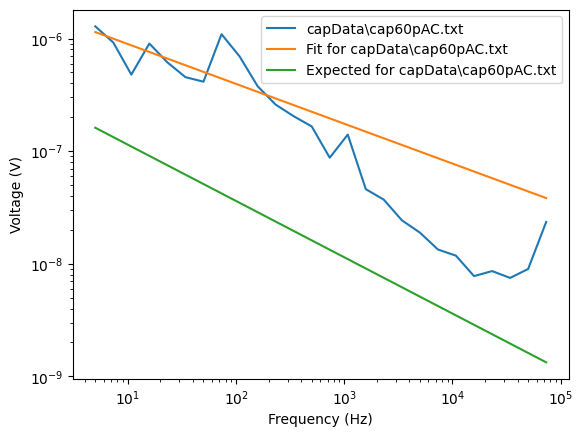

Expected:  (5.9475+/-0.0011)e-06
Fit:  [1.96233644e-06 2.51767402e-01] [[1.47716200e-12 1.69625481e-07]
 [1.69625481e-07 2.49688117e-02]]


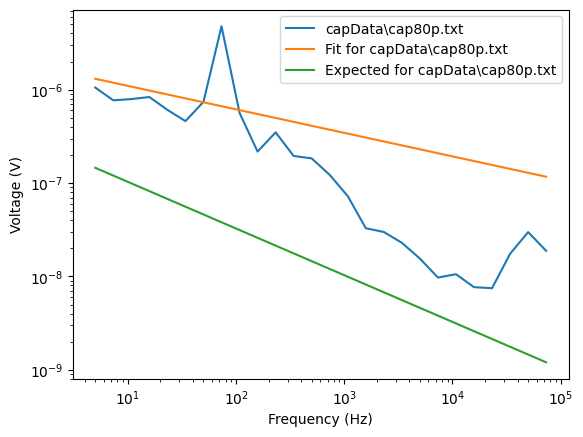

In [90]:
capacitances = [unc.ufloat(47.1, 0.01)*1e-12, unc.ufloat(60.0, 0.01)*1e-12, unc.ufloat(73.6, 0.01)*1e-12]
ds = [unc.ufloat(0.013, 0.001), unc.ufloat(0.003, 0.001), unc.ufloat(0.003, 0.001)]
data = glob.glob("capData/*.txt")
T = unc.ufloat(273.3 + 22.9, 0.1)
for file, cap, d in zip(data, capacitances, ds):
    f, V = readData(file)
    vsWithUnc = [unc.ufloat(v, uncPctHundred)/transfer(F, cap, d) for v, F in zip(V, f)]
    vsNoUnc = [v.n for v in vsWithUnc]
    vsUnc = [v.s for v in vsWithUnc]
    popt, pcov = curve_fit(curveFit, f, vsNoUnc, p0=[0, 1], sigma=vsUnc)
    expect = []
    for F in f:
        expect.append(expected(F, cap.n, d.n, T.n))
    plt.plot(f, vsNoUnc, label=file)
    plt.plot(f, curveFit(f, *popt), label="Fit for " + file)
    plt.plot(f, expect, label="Expected for " + file)
    print("Expected: ", expectedSlope(cap, d, T))
    print("Fit: ", popt, pcov)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Voltage (V)")
    plt.legend()
    plt.show()